In [1]:
import json
import torch
from q_storm.StormSampler import StormSampler
from varpi.tain_varpi import VarPi

device = "cuda" if torch.cuda.is_available() else "cpu"

with open('config.json') as f:
    config = json.load(f)
    
taus = config["general"]["quantiles"]

sampler = StormSampler(device, taus)

/home/chaddicus/miniconda3/envs/opt-price/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-30 16:57:57,648] Using an existing study with name 'wasserstein_distance_qlstm' instead of creating a new one.
/home/chaddicus/opt-price/q_storm/StormSampler.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be

In [2]:
q_strom = torch.load("models/2q_storm.pth")
varpi = torch.load("models/varpi.pth")

/tmp/ipykernel_12386/1370889862.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_strom = torch.load("models/2q_storm.pth")
/tmp/ipykernel_12386/1370889862.py:2: FutureW

In [3]:
sampled_point = sampler.sample(1)
S_prime_test = torch.linspace(0, 5, 100).view(-1, 1)
tau_test = torch.linspace(0, 30, 100).view(-1, 1)
S_grid, T_grid = torch.meshgrid(S_prime_test.squeeze(), tau_test.squeeze())
S_grid = S_grid.reshape(-1, 1)
T_grid = T_grid.reshape(-1, 1)
rf = sampled_point["rf"]
varphi_q = sampled_point["varphi_q"]

# Expand rf to match the grid shape (broadcasting across S_grid and T_grid)
rf_grid = rf.expand(S_grid.shape[0], 1)

S_grid = S_grid.to(device)
T_grid = T_grid.to(device)
rf_grid = rf_grid.to(device)
print(varphi_q.mean())

tensor(-0.0066, device='cuda:0', grad_fn=<MeanBackward0>)


/home/chaddicus/miniconda3/envs/opt-price/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
T_prime_grid = torch.max(T_grid, torch.ones_like(T_grid)*15)
t_prime_grid = T_grid/T_prime_grid
T_prime_grid = T_prime_grid/30
varphi_q_grid = varphi_q.expand(S_grid.shape[0], -1)

In [5]:
varpi_q = varpi(varphi_q_grid, t_prime_grid, T_prime_grid)

In [6]:
V_prime = q_strom(S_grid, T_grid, varpi_q, rf_grid)

In [7]:
cpu_S_grid = S_grid.cpu().detach().numpy().reshape(100, 100)
cpu_T_grid = T_grid.cpu().detach().numpy().reshape(100, 100)
cpu_V_prime = V_prime.cpu().detach().numpy().reshape(100, 100)

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

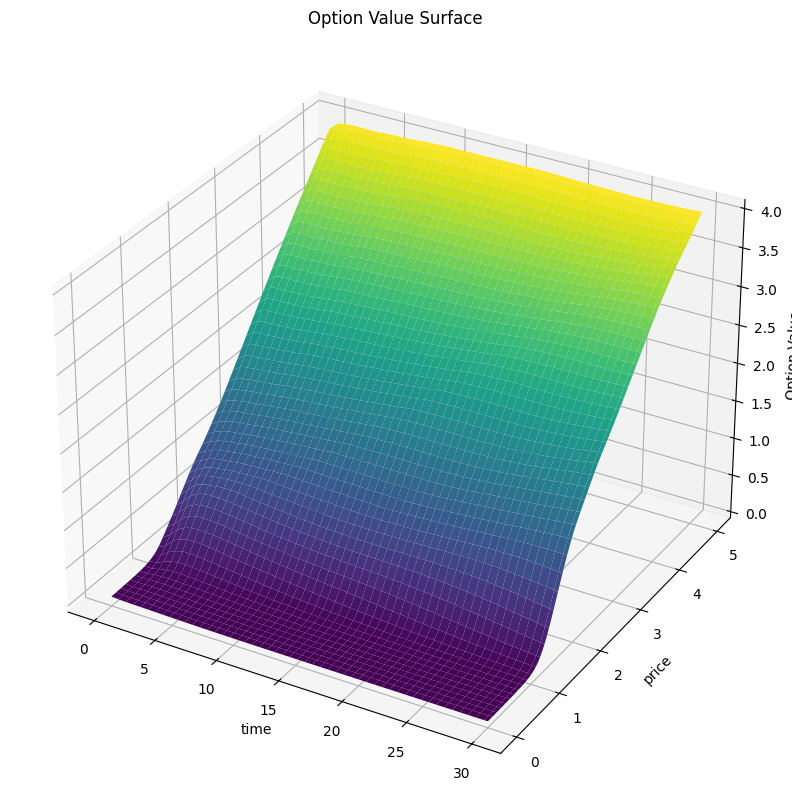

In [9]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot surface
surf = ax.plot_surface(cpu_T_grid, cpu_S_grid, cpu_V_prime, cmap="viridis", edgecolor="none")

# Labels and title
ax.set_xlabel("time")
ax.set_ylabel("price")
ax.set_zlabel("Option Value")
ax.set_title("Option Value Surface")

# Color bar
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [10]:
cpu_V_prime.max()

np.float32(4.0290294)